In [11]:
# %% Initializing data and packages
import spacy
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import nltk
nltk.download('vader_lexicon')

def init_spacy_model():
    return spacy.load("en_core_web_sm")

nlp = init_spacy_model()


# Define any filler words if not already defined.
FILLER_WORDS = {
    "the", "a", "an", "um", "uh", "like", "and", "but", "or", "so", "really", "very", 
    "rt", "amp", "link", "bio", "reactions", "shares", "noopener", "noreferrer", 
    "nofollow", "sponsored", "ad", "advertisement", "advertising", 'class="u', 
    'class="twitter', 'class="twitter-tweet', 'class="twitter-tweet"', "url",
    'mention">@<span'
}

# Global column names and state list.
STATES = ['AZ', 'GA', 'MI', 'NC', 'NV', 'PA', 'WI']
TEXT_COLUMN = 'attributes.search_data_fields.all_text'
DATE_COLUMN = 'attributes.created_at'

# --- Function Definitions ---
def extract_nouns_by_type(text, nlp, filler_words=FILLER_WORDS):
    """
    Process the text with spaCy and return a dictionary with counts for:
      - 'common': tokens tagged as NOUN (excluding filler words and tokens shorter than 2 characters)
      - 'proper': tokens tagged as PROPN, or tokens from named entities (PERSON, GPE, LOC)
    """
    text = str(text)  # Convert input to a plain Python string
    doc = nlp(text)
    counts = {"common": 0, "proper": 0}
    
    # Process named entities as proper nouns.
    for ent in doc.ents:
        if ent.label_ in {'PERSON', 'GPE', 'LOC'}:
            ent_text = ent.text.lower().strip()
            if len(ent_text) > 1 and ent_text not in filler_words:
                counts["proper"] += 1
    
    # Process individual tokens not part of an entity.
    for token in doc:
        if token.ent_iob_ == 'O':  # token not part of any entity
            token_text = token.text.lower().strip()
            if len(token_text) > 1 and token_text not in filler_words:
                if token.pos_ == 'NOUN':
                    counts["common"] += 1
                elif token.pos_ == 'PROPN':
                    counts["proper"] += 1
    return counts

def compute_common_vs_proper_ratio(texts, nlp):
    """
    Given an iterable of texts, aggregate the common and proper noun counts,
    and return the ratio proper/common.
    """
    total_common = 0
    total_proper = 0
    for text in texts:
        if isinstance(text, str):
            counts = extract_nouns_by_type(text, nlp)
            total_common += counts["common"]
            total_proper += counts["proper"]
    return total_proper / total_common if total_common > 0 else 0


[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/evacapelsonschool/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [ ]:
# %% Loading data and creating a sample of swing states
# Adjust the file path to your dataset.

def load_data(filepath, states, max_rows_per_state=5000):
    """
    Load the dataset from a Parquet file, filter by the specified states,
    and sample up to max_rows_per_state entries per state.
    """
    df = pd.read_parquet(filepath, engine='pyarrow')
    df_filtered = df[df['actor_attributes.State'].isin(states)]
    samples = []
    for state in states:
        df_state = df_filtered[df_filtered['actor_attributes.State'] == state]
        # If there are more than max_rows_per_state entries, sample max_rows_per_state.
        if len(df_state) >= max_rows_per_state:
            sample_state = df_state.sample(n=max_rows_per_state, random_state=42)
        else:
            sample_state = df_state
        samples.append(sample_state)
    return pd.concat(samples)

# Specify the file path and state list.
FILEPATH = '/Users/evacapelsonschool/Downloads/detailed_posts_.parquet'  # Adjust this path accordingly
STATES = ['AZ', 'GA', 'MI', 'NC', 'NV', 'PA', 'WI']

# Load the data with a maximum of 5000 entries per state.
fed_sample_swing = load_data(FILEPATH, STATES, max_rows_per_state=5000)

# Optionally, display the counts by state.
print(fed_sample_swing['actor_attributes.State'].value_counts())


actor_attributes.State
AZ    5000
GA    5000
MI    5000
NC    5000
NV    5000
PA    5000
WI    5000
Name: count, dtype: int64


In [4]:
# %% Ratio by State
proper_common_ratio_state = {}
for state in STATES:
    state_texts = fed_sample_swing.loc[
        fed_sample_swing['actor_attributes.State'] == state, TEXT_COLUMN
    ]
    ratio = compute_common_vs_proper_ratio(state_texts, nlp)
    proper_common_ratio_state[state] = ratio

# Display the computed ratios.
print("Proper/Common Ratio by State:")
for state, ratio in proper_common_ratio_state.items():
    print(f"{state}: {ratio:.3f}")

Proper/Common Ratio by State:
AZ: 0.591
GA: 0.613
MI: 0.412
NC: 0.492
NV: 0.457
PA: 0.496
WI: 0.502


In [5]:
# %% Ratio by Party
# You can either specify a list of parties or use all unique values from the column.
selected_parties = ['Democratic Party', 'Republican Party']
proper_common_ratio_party = {}

for party in selected_parties:
    party_texts = fed_sample_swing.loc[
        fed_sample_swing['actor_attributes.Registered Political Party'] == party, TEXT_COLUMN
    ]
    ratio = compute_common_vs_proper_ratio(party_texts, nlp)
    proper_common_ratio_party[party] = ratio

# Display the computed ratios.
print("Proper/Common Ratio by Political Party:")
for party, ratio in proper_common_ratio_party.items():
    print(f"{party}: {ratio:.3f}")

Proper/Common Ratio by Political Party:
Democratic Party: 0.406
Republican Party: 0.602


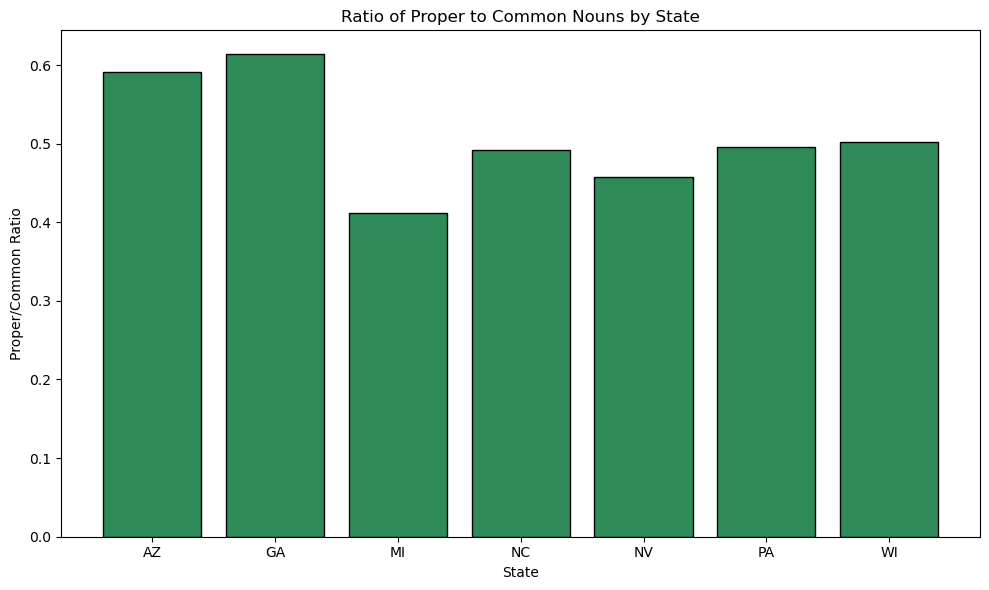

In [6]:
# %% Visualizing Ratio by State
plt.figure(figsize=(10, 6))
plt.bar(list(proper_common_ratio_state.keys()), list(proper_common_ratio_state.values()),
        color='seagreen', edgecolor='black')
plt.xlabel("State")
plt.ylabel("Proper/Common Ratio")
plt.title("Ratio of Proper to Common Nouns by State")
plt.tight_layout()
plt.show()

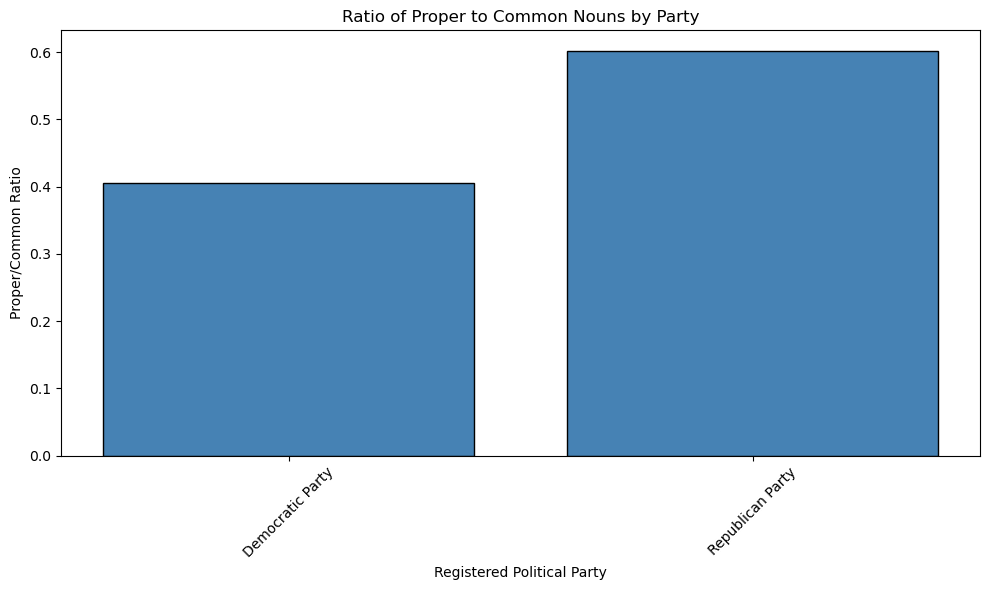

In [7]:
# %% Visualizing Ratio by Party
plt.figure(figsize=(10, 6))
plt.bar(list(proper_common_ratio_party.keys()), list(proper_common_ratio_party.values()),
        color='steelblue', edgecolor='black')
plt.xlabel("Registered Political Party")
plt.ylabel("Proper/Common Ratio")
plt.title("Ratio of Proper to Common Nouns by Party")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

LOOKING AT PROPER NOUN FREQUENCIES

In [9]:
def extract_proper_nouns_list(text, nlp, filler_words=FILLER_WORDS):
    """
    Process the text with spaCy and return a list of proper nouns.
    It extracts tokens from named entities (with labels like PERSON, GPE, LOC)
    and individual tokens tagged as PROPN that aren't part of an entity.
    """
    proper_nouns = []
    text = str(text)  # Ensure text is a string
    doc = nlp(text)
    
    # Extract from named entities.
    for ent in doc.ents:
        if ent.label_ in {'PERSON', 'GPE', 'LOC'}:
            ent_text = ent.text.lower().strip()
            if len(ent_text) > 1 and ent_text not in filler_words:
                proper_nouns.append(ent_text)
    
    # Extract individual tokens not already in an entity.
    for token in doc:
        if token.ent_iob_ == 'O':  # token is not part of any entity
            token_text = token.text.lower().strip()
            if len(token_text) > 1 and token_text not in filler_words and token.pos_ == 'PROPN':
                proper_nouns.append(token_text)
    
    return proper_nouns

In [10]:
from collections import Counter

selected_parties = ['Democratic Party', 'Republican Party']
proper_noun_counts_by_party = {}

for party in selected_parties:
    # Filter the texts by the political party.
    party_texts = fed_sample_swing.loc[
        fed_sample_swing['actor_attributes.Registered Political Party'] == party, TEXT_COLUMN
    ]
    
    # Apply the proper noun extraction to each text.
    proper_nouns_series = party_texts.apply(lambda text: extract_proper_nouns_list(text, nlp))
    
    # Flatten the list of lists.
    all_proper_nouns = [noun for sublist in proper_nouns_series for noun in sublist]
    
    # Count frequencies.
    proper_noun_counts_by_party[party] = Counter(all_proper_nouns)
    
    # Display the top 10 proper nouns for each party.
    print(f"Top proper nouns for {party}:")
    for noun, count in proper_noun_counts_by_party[party].most_common(10):
        print(f"  {noun}: {count}")
    print("\n")

Top proper nouns for Democratic Party:
  nevada: 937
  president: 702
  michigan: 582
  wisconsin: 471
  u.s.: 438
  georgia: 360
  america: 352
  arizona: 340
  senator: 292
  biden: 254


Top proper nouns for Republican Party:
  president: 2227
  trump: 1560
  america: 1310
  biden: 1139
  arizona: 683
  rep.: 623
  joe biden: 533
  u.s.: 489
  senator: 405
  kamala harris: 397




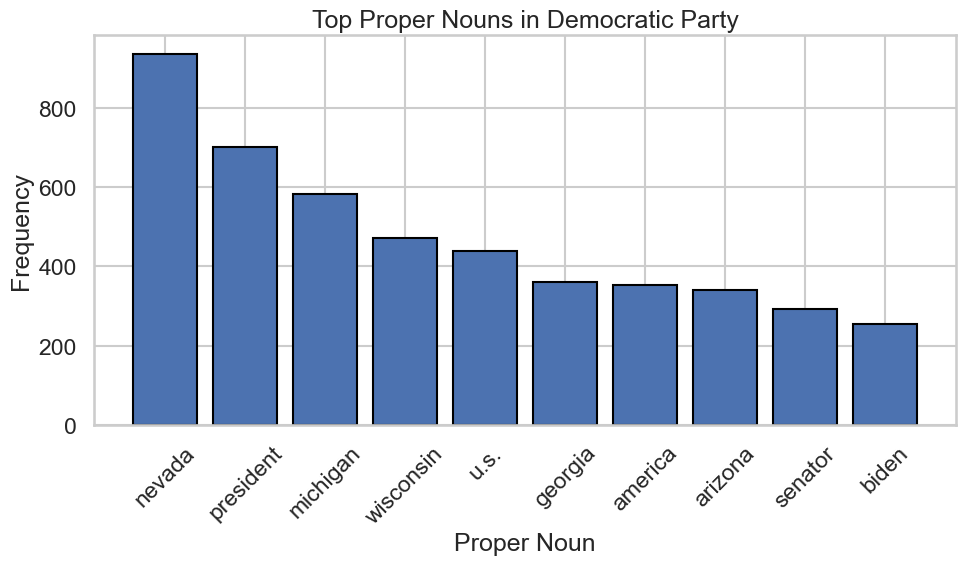

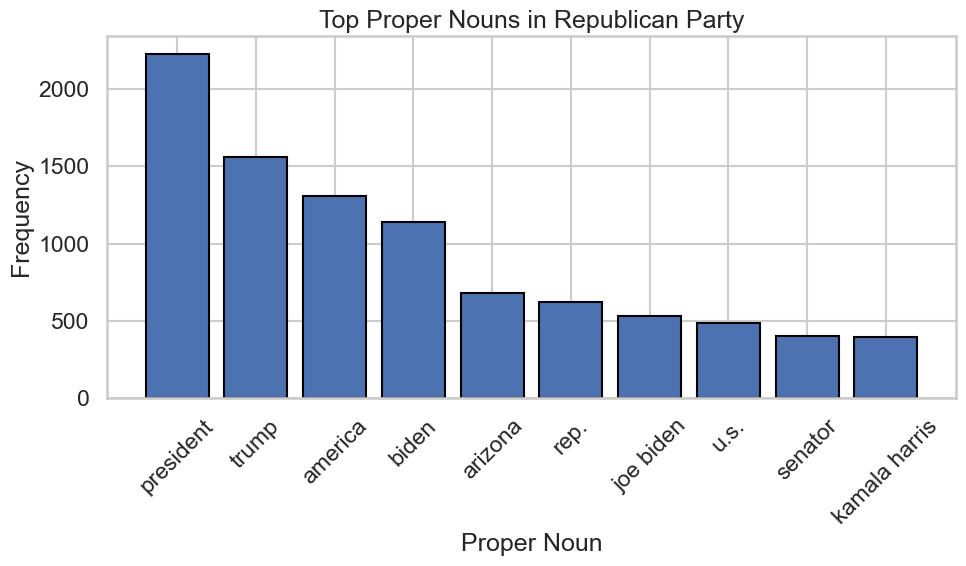

In [8]:
for party in selected_parties:
    top_nouns = proper_noun_counts_by_party[party].most_common(10)
    if top_nouns:
        nouns, counts = zip(*top_nouns)
        plt.figure(figsize=(10, 6))
        plt.bar(nouns, counts, edgecolor='black')
        plt.xlabel("Proper Noun")
        plt.ylabel("Frequency")
        plt.title(f"Top Proper Nouns in {party}")
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()

BUILDING A MORE ADVANCED DISPLAY OF PROPER/COMMON NOUN RATIOS PER PARTY

In [13]:
import numpy as np

def precompute_counts(texts, nlp):
    """
    Precompute and return a list of noun counts for each text.
    Each element is a dictionary with keys 'common' and 'proper'.
    """
    counts_list = []
    for text in texts:
        if isinstance(text, str):
            counts = extract_nouns_by_type(text, nlp)
            counts_list.append(counts)
    return counts_list

def bootstrap_common_proper_ratio_precomputed(counts_list, n_boot=1000, random_state=42):
    """
    Perform bootstrap resampling on the precomputed counts list to estimate
    the mean proper/common ratio and a 95% confidence interval.
    
    Parameters:
      counts_list: List of precomputed count dictionaries for texts.
      n_boot: Number of bootstrap iterations.
      random_state: Seed for reproducibility.
      
    Returns:
      mean_ratio: The mean ratio from bootstrap samples.
      lower: Lower bound of the 95% confidence interval.
      upper: Upper bound of the 95% confidence interval.
    """
    np.random.seed(random_state)
    N = len(counts_list)
    boot_ratios = []
    for i in range(n_boot):
        sample_indices = np.random.choice(N, size=N, replace=True)
        sample = [counts_list[idx] for idx in sample_indices]
        total_common = sum(d['common'] for d in sample)
        total_proper = sum(d['proper'] for d in sample)
        ratio = total_proper / total_common if total_common > 0 else 0
        boot_ratios.append(ratio)
    boot_ratios = np.array(boot_ratios)
    mean_ratio = np.mean(boot_ratios)
    lower = np.percentile(boot_ratios, 2.5)
    upper = np.percentile(boot_ratios, 97.5)
    return mean_ratio, lower, upper

In [4]:
selected_parties = ['Democratic Party', 'Republican Party']
proper_common_ratio_party = {}

for party in selected_parties:
    party_texts = fed_sample_swing.loc[
        fed_sample_swing['actor_attributes.Registered Political Party'] == party, TEXT_COLUMN
    ]
    # Precompute counts for this party's texts.
    counts_list = precompute_counts(party_texts, nlp)
    # Compute bootstrap estimates (adjust n_boot if needed).
    mean_ratio, lower, upper = bootstrap_common_proper_ratio_precomputed(counts_list, n_boot=1000)
    proper_common_ratio_party[party] = (mean_ratio, lower, upper)

# Print computed values.
print("Proper/Common Ratio by Political Party with 95% CI:")
for party, (mean_ratio, lower, upper) in proper_common_ratio_party.items():
    print(f"{party}: {mean_ratio:.3f} (95% CI: {lower:.3f} - {upper:.3f})")

Proper/Common Ratio by Political Party with 95% CI:
Democratic Party: 0.406 (95% CI: 0.398 - 0.415)
Republican Party: 0.602 (95% CI: 0.592 - 0.613)


/var/folders/rg/25lzk3bx5nn2wb1f58kpgfh40000gq/T/ipykernel_86772/348449488.py:22: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  ax = sns.barplot(x='Party', y='Mean', data=df_plot, palette="coolwarm", ci=None)
/var/folders/rg/25lzk3bx5nn2wb1f58kpgfh40000gq/T/ipykernel_86772/348449488.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='Party', y='Mean', data=df_plot, palette="coolwarm", ci=None)


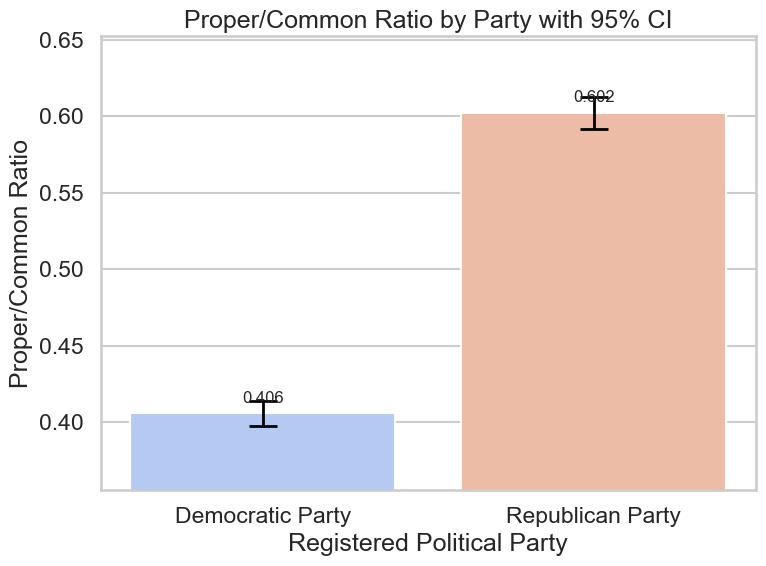

In [14]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

# Convert the dictionary into a DataFrame.
data = []
for party, (mean_ratio, lower, upper) in proper_common_ratio_party.items():
    error = mean_ratio - lower  # Assuming symmetric error bars.
    data.append({
        'Party': party,
        'Mean': mean_ratio,
        'Lower': lower,
        'Upper': upper,
        'Error': error
    })
df_plot = pd.DataFrame(data)

# Set Seaborn style.
sns.set(style="whitegrid", context="talk")

plt.figure(figsize=(8,6))
ax = sns.barplot(x='Party', y='Mean', data=df_plot, palette="coolwarm", ci=None)

# Add enhanced error bars.
ax.errorbar(x=np.arange(len(df_plot)), y=df_plot['Mean'], 
            yerr=df_plot['Error'],
            fmt='none', c='black', capsize=10, elinewidth=2, capthick=2)

# Annotate each bar with the exact mean value.
for i, row in df_plot.iterrows():
    ax.text(i, row['Mean'] + 0.005, f"{row['Mean']:.3f}", ha='center', va='bottom', fontsize=12)

# Optionally adjust y-axis limits.
ymin = df_plot['Mean'].min() - 0.05
ymax = df_plot['Mean'].max() + 0.05
ax.set_ylim(ymin, ymax)

ax.set_xlabel("Registered Political Party")
ax.set_ylabel("Proper/Common Ratio")
ax.set_title("Proper/Common Ratio by Party with 95% CI")
plt.tight_layout()
plt.show()


/var/folders/rg/25lzk3bx5nn2wb1f58kpgfh40000gq/T/ipykernel_86772/3899466503.py:5: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  fed_sample_swing['Month'] = fed_sample_swing['datetime'].dt.to_period('M').dt.to_timestamp()


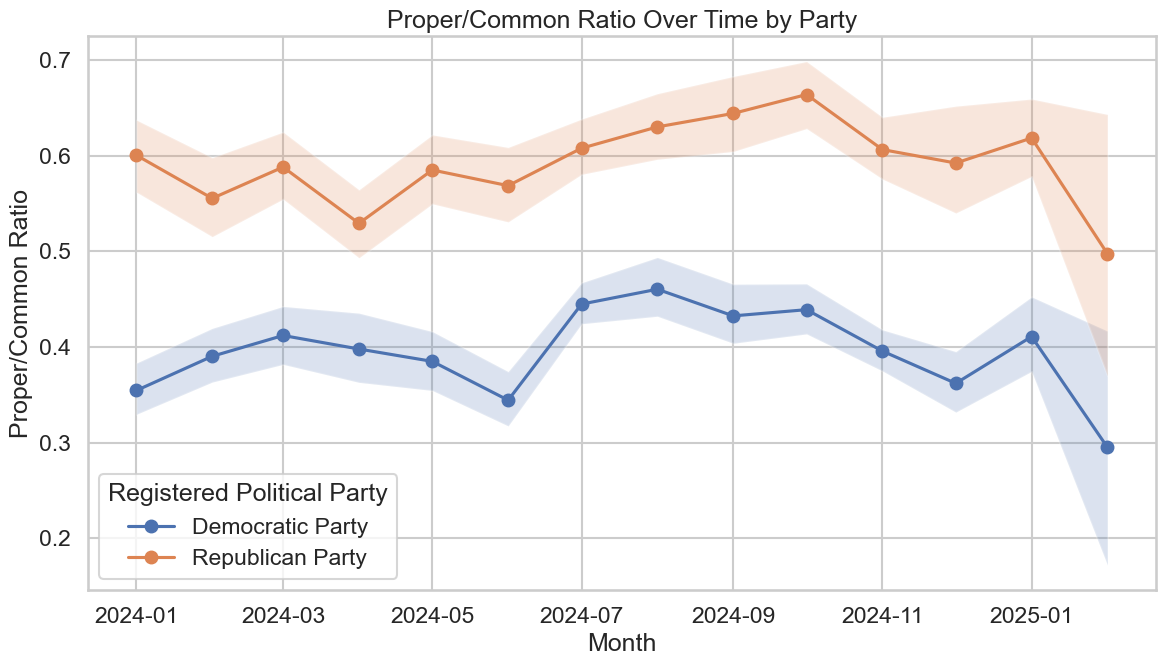

In [ ]:
# %% Visualization: Proper/Common Ratio Over Time by Party with Confidence Intervals

# Convert the date column to datetime and create a monthly time bin.
fed_sample_swing['datetime'] = pd.to_datetime(fed_sample_swing[DATE_COLUMN])
fed_sample_swing['Month'] = fed_sample_swing['datetime'].dt.to_period('M').dt.to_timestamp()

# Aggregate results for each party and month.
results = []
for party in selected_parties:
    party_df = fed_sample_swing[fed_sample_swing['actor_attributes.Registered Political Party'] == party]
    # Group by month.
    for month, group in party_df.groupby('Month'):
        texts = group[TEXT_COLUMN]
        # Precompute noun counts for the texts.
        counts_list = precompute_counts(texts, nlp)
        # Compute bootstrap estimates (mean ratio, lower & upper CI bounds).
        mean_ratio, lower, upper = bootstrap_common_proper_ratio_precomputed(counts_list, n_boot=1000)
        results.append({
            'Party': party,
            'Month': month,
            'Mean': mean_ratio,
            'Lower': lower,
            'Upper': upper
        })

# Convert results into a DataFrame and sort by month.
df_time = pd.DataFrame(results)
df_time.sort_values(by='Month', inplace=True)

# Plot the line graph with confidence interval bands.
plt.figure(figsize=(12, 7))

# Plot a line for each party with confidence interval bands.
for party in selected_parties:
    party_data = df_time[df_time['Party'] == party].sort_values('Month')
    plt.plot(party_data['Month'], party_data['Mean'], marker='o', label=party)
    plt.fill_between(party_data['Month'], party_data['Lower'], party_data['Upper'], alpha=0.2)

plt.xlabel("Month")
plt.ylabel("Proper/Common Ratio")
plt.title("Proper/Common Ratio Over Time by Party")
plt.legend(title="Registered Political Party")
plt.tight_layout()
plt.show()